In [102]:
import pandas as pd
import matplotlib.pyplot as plt

In [103]:
user_id = 14781

training_data = pd.read_csv("../../data/usage_forecasting/user_data_" + str(user_id) + "_training.csv")
validation_data = pd.read_csv("../../data/usage_forecasting/user_data_" + str(user_id) + "_validation.csv", header=None)
#rename validation_data columns
validation_data.columns = ['datetime', 'value',"status"]

chronos_forecast = pd.read_csv("../../data/usage_forecasting/user_data_" + str(user_id) + "_forecast_chronos.csv")
prophet_forecast = pd.read_csv("../../data/usage_forecasting/user_data_" + str(user_id) + "_forecast_prophet.csv")

In [104]:
# Convert datetime columns to datetime objects first
validation_data['datetime'] = pd.to_datetime(validation_data['datetime'])
chronos_forecast['datetime'] = pd.to_datetime(chronos_forecast['datetime'])
prophet_forecast['ds'] = pd.to_datetime(prophet_forecast['ds'])

/var/folders/p9/70zj6cs52fs9xb652cxfzgnm0000gn/T/ipykernel_75285/444253891.py:2: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  validation_data['datetime'] = pd.to_datetime(validation_data['datetime'])


In [105]:
# Select entries from prophet_forecast between 2024-09-01 00:00:00 and 2024-09-08 00:00:01
start_date = pd.Timestamp("2024-09-01 00:00:00")
end_date = pd.Timestamp("2024-09-08 00:00:01")
prophet_forecast_week = prophet_forecast[(prophet_forecast['ds'] >= start_date) & (prophet_forecast['ds'] <= end_date)]

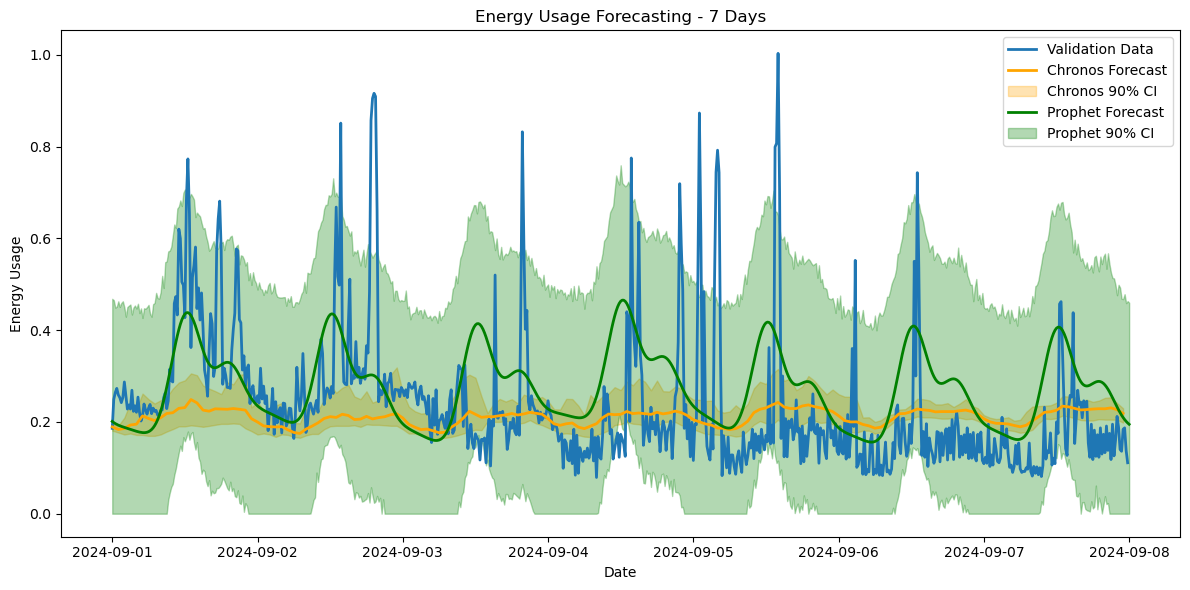

In [106]:
# plot first 7 days of validation data and chronos forecast with confidence intervals
plt.figure(figsize=(12, 6))
plt.plot(validation_data['datetime'][:24*4*7], validation_data['value'][:24*4*7], label='Validation Data', linewidth=2)
plt.plot(chronos_forecast['datetime'], chronos_forecast['usage_forecast_mean'], label='Chronos Forecast', linewidth=2, color='orange')

# Add 90% confidence intervals with matching color
plt.fill_between(chronos_forecast['datetime'], 
                 chronos_forecast['usage_lower_95'], 
                 chronos_forecast['usage_upper_95'], 
                 alpha=0.3, label='Chronos 90% CI', color='orange')

# include yhat, yhat_lower, yhat_upper from prophet forecast with matching colors
plt.plot(prophet_forecast_week['ds'], prophet_forecast_week['yhat'], label='Prophet Forecast', color='green', linewidth=2)
plt.fill_between(prophet_forecast_week['ds'], 
                 prophet_forecast_week['yhat_lower'], 
                 prophet_forecast_week['yhat_upper'], 
                 alpha=0.3, label='Prophet 90% CI', color='green')

plt.xlabel('Date')
plt.ylabel('Energy Usage')
plt.title('Energy Usage Forecasting - 7 Days')
plt.legend()
plt.tight_layout()
plt.show()

In [107]:
#resample validation data to hourly averages
validation_data_hourly = validation_data.drop(columns=["status"])
validation_data_hourly = validation_data_hourly.resample('H', on='datetime').mean().reset_index()

In [108]:
# Select entries from prophet_forecast between 2024-09-01 00:00:00 and 2024-10-01 00:00:01
start_date = pd.Timestamp("2024-09-01 00:00:00")
end_date = pd.Timestamp("2024-10-01 00:00:01")
prophet_forecast_sept = prophet_forecast[(prophet_forecast['ds'] >= start_date) & (prophet_forecast['ds'] <= end_date)]

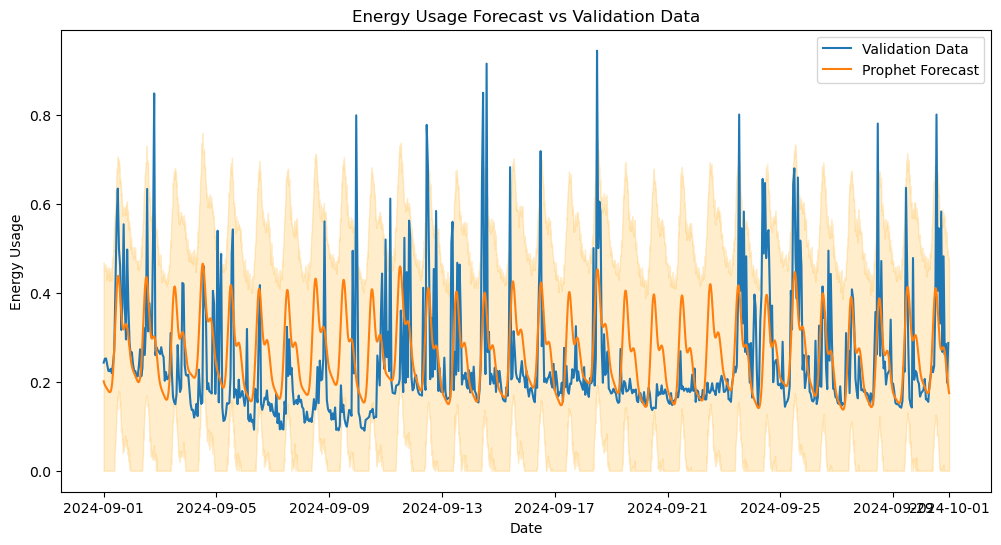

In [109]:
# plot 30 days of validation data and the prophet forecast
plt.figure(figsize=(12, 6))
plt.plot(validation_data_hourly['datetime'][:30*24], validation_data_hourly['value'][:30*24], label='Validation Data')
plt.plot(prophet_forecast_sept['ds'], prophet_forecast_sept['yhat'], label='Prophet Forecast')
plt.fill_between(prophet_forecast_sept['ds'], prophet_forecast_sept['yhat_lower'], prophet_forecast_sept['yhat_upper'], alpha=0.2, color='orange')
plt.xlabel('Date')
plt.ylabel('Energy Usage')
plt.title('Energy Usage Forecast vs Validation Data')
plt.legend()
plt.show()

In [110]:
# compare actual vs forecasted usage - corrected version

# For validation data (15-min intervals): 30 days * 24 hours * 4 intervals = 2,880 points
usage_actual_sum = validation_data['value'][:30*24*4].sum()

# For prophet forecast: use all September data (already filtered by date)
usage_forecast_sum = prophet_forecast_sept['yhat'].sum()

usage_forecast_lower = prophet_forecast_sept['yhat_lower'].sum()
usage_forecast_upper = prophet_forecast_sept['yhat_upper'].sum()

print(f"Actual Usage (30 days): {usage_actual_sum * 0.25} kWh")
print(f"Forecasted Usage (30 days): {usage_forecast_sum * 0.25} kWh")
print(f"Forecasted Usage Lower Bound (30 days): {usage_forecast_lower * 0.25} kWh")
print(f"Forecasted Usage Upper Bound (30 days): {usage_forecast_upper * 0.25} kWh")

Actual Usage (30 days): 173.3865 kWh
Forecasted Usage (30 days): 190.5567199248261 kWh
Forecasted Usage Lower Bound (30 days): 22.512140323108078 kWh
Forecasted Usage Upper Bound (30 days): 385.1654650703682 kWh


In [111]:
# evaluate forecast quality
from sklearn.metrics import mean_absolute_error, root_mean_squared_error

mae = mean_absolute_error(validation_data['value'][:30*24*4], prophet_forecast_sept['yhat'])
print(f"Mean Absolute Error (30 days): {mae} kWh")

rmse = root_mean_squared_error(validation_data['value'][:30*24*4], prophet_forecast_sept['yhat'])
print(f"Root Mean Square Error (30 days): {rmse} kWh")

# Get overlapping time period
start_date = prophet_forecast_sept['ds'].min()
end_date = prophet_forecast_sept['ds'].max()

# Filter validation data by datetime values (not index)
validation_mask = (validation_data['datetime'] >= start_date) & (validation_data['datetime'] <= end_date)
validation_aligned = validation_data[validation_mask]

print(validation_aligned.shape)
print(prophet_forecast_sept.shape)

# Ensure both have same length
min_length = min(len(validation_aligned), len(prophet_forecast_sept))
validation_values = validation_aligned['value'].iloc[:min_length].values
forecast_lower = prophet_forecast_sept['yhat_lower'].iloc[:min_length].values
forecast_upper = prophet_forecast_sept['yhat_upper'].iloc[:min_length].values

# Calculate coverage
coverage = ((validation_values >= forecast_lower) & (validation_values <= forecast_upper)).mean()
print(f"Coverage (30 days): {coverage:.3f}")

Mean Absolute Error (30 days): 0.10654767337077528 kWh
Root Mean Square Error (30 days): 0.1594433832707473 kWh
(2880, 3)
(2880, 19)
Coverage (30 days): 0.931
